In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.idl import readsav
from scipy.signal import find_peaks
import pickle 
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy import units as u
import numpy.ma as ma
from astropy.stats import sigma_clip
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import mpl_toolkits.axes_grid1.axes_grid as axes_grid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Ellipse
import math
from matplotlib import cm
from astropy.wcs import WCS
import scipy
import scipy.ndimage as ndi
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import pkg_resources
from astropy.modeling import models
from __future__ import print_function
import pandas as pd
import pylab as pl

C:\Users\lucys\AppData\Local\Temp\ipykernel_19964\3113644397.py:3: DeprecationWarning: Please use `readsav` from the `scipy.io` namespace, the `scipy.io.idl` namespace is deprecated.
  from scipy.io.idl import readsav


In [2]:
d_vals = pd.DataFrame({'12CO':[0.25, 0.12],
                      '13CO':[0.25, 0.1],
                      'C18O':[0.28, 0.15], 
                      'CCH':[0.25, 0.15],
                      'CCH_32':[0.15, 0.08],
                      'HC3N':[0.3, 0.25],
                      'HCN':[0.06, 0.08], 
                      'HCN_32':[0.065, 0.04], 
                      'HCOp':[0.08, 0.1], 
                      'HCOp_32':[0.1, 0.08], 
                      'HNC':[0.3, 0.08], 
                      'HNC_32':[0.2, 0.12]})

def opt_depth_map(globule ='GlobB', source = '12CO'):
    #globule = 'GlobB'
    #source = '12CO'
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header

    data1 = data[0,:,:,:]
    h = 6.62608e-34
    k = 1.38065e-23

    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)

    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    channels = np.arange(header["NAXIS3"])

    frequency = freq_start + (freq_inc * channels)
    frequency = np.array(frequency, dtype = float)

    freq_start_ghz = header["CRVAL3"]/1e9
    freq_inc_ghz = header["CDELT3"]/1e9
    frequency_ghz = freq_start_ghz + (freq_inc_ghz * channels)
    frequency_ghz = np.array(frequency_ghz, dtype = float)

    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000
    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000

    if globule == 'GlobB':
        x1 = round(header["CRPIX1"]-(ra_start-337.43248)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.428)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.8175)/dec_inc)-2
        y2 = round(header["CRPIX2"]-(dec_start+20.81354)/dec_inc)-2
    elif globule == 'GlobC':
        x1 = round(header["CRPIX1"]-(ra_start-337.40975)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.40565)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.803)/dec_inc)-2
        y2 = round(header["CRPIX2"]-(dec_start+20.797)/dec_inc)-2

    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]

    hnu_k = h*frequency[0]/k

    integrated = np.sum(data3[:, :, :], axis = 0)

    max_val = np.nanmax(integrated)

    a = [x for x in range(len(data1[:, 0, 0]))]
    array = []
    for i in range(len(a)):
        if np.nanmax(data3[a[i], :, :]) > d_vals[source][0]*max_val:
            array.append(a[i])
    extent=[ra[x1],ra[x2],dec[y1],dec[y2]]

    moment0 = np.sum(data3[array, :, :], axis = 0)*abs(vel_inc)
    sigma_mask = sigma_clip(moment0, sigma=3, maxiters=None, cenfunc='mean')
    newmask = (moment0 < np.amax(sigma_mask))
    mom0 = np.ma.array(moment0, mask = newmask)
    bmaj = header['BMAJ']#major beam width
    bmin = header['BMIN']#minor beam width
    I = np.nanmax(mom0)    
    t_mb = 1.222e3*mom0*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    #Tex = 24.96 #Globule C
    Tex = 23.94604986 #Globule B
    den = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb/hnu_k
    almost = 1-den
    opt_depth_map = -np.log(almost) 
    return opt_depth_map
    #print(extent)

In [3]:
source_array = ['12CO', '13CO', 'C18O', 'CCH', 'CCH_32', 'HC3N', 'HCN', 'HCN_32', 'HCOp', 'HCOp_32', 'HNC', 'HNC_32']

ra_lists = []
dec_lists = []
for i in source_array:
    path = 'GlobB_' + i + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header

    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    ra_lists.append(ra)
    dec_lists.append(dec)

ra_and_dec = pd.DataFrame({'12CO':[ra_lists[0], dec_lists[0]],
                          '13CO':[ra_lists[1], dec_lists[1]],
                          'C18O':[ra_lists[2], dec_lists[2]],
                          'CCH':[ra_lists[3], dec_lists[3]], 
                          'CCH_32':[ra_lists[4], dec_lists[4]],
                          'HC3N':[ra_lists[5], dec_lists[5]],
                          'HCN':[ra_lists[6], dec_lists[6]],
                          'HCN_32':[ra_lists[7], dec_lists[7]],
                          'HCOp':[ra_lists[8], dec_lists[8]],
                          'HCOp_32':[ra_lists[9], dec_lists[9]],
                          'HNC':[ra_lists[10], dec_lists[10]],
                          'HNC_32':[ra_lists[11], dec_lists[11]]})

display(ra_and_dec)

,12CO,13CO,C18O,CCH,CCH_32,HC3N,HCN,HCN_32,HCOp,HCOp_32,HNC,HNC_32
0,"[337.43559971, 337.43554971, 337.43549971, 337...","[337.43559971, 337.43554971, 337.43549971, 337...","[337.43559971, 337.43554971, 337.43549971, 337...","[337.44351234976665, 337.4434651275444, 337.44...","[337.4347668407667, 337.4347307296556, 337.434...","[337.44351234976665, 337.4434651275444, 337.44...","[337.44351234976665, 337.4434651275444, 337.44...","[337.4347668407667, 337.4347307296556, 337.434...","[337.44351234976665, 337.4434651275444, 337.44...","[337.43323910658887, 337.4332002177, 337.43316...","[337.44351234976665, 337.4434651275444, 337.44...","[337.43323910658887, 337.4332002177, 337.43316..."
1,"[-20.82366516796, -20.82361516796, -20.8235651...","[-20.82366516796, -20.82361516796, -20.8235651...","[-20.82366516796, -20.82361516796, -20.8235651...","[-20.831582244406665, -20.831535022184443, -20...","[-20.822831817086666, -20.822795705975555, -20...","[-20.831582244406665, -20.831535022184443, -20...","[-20.831582244406665, -20.831535022184443, -20...","[-20.822831817086666, -20.822795705975555, -20...","[-20.831582244406665, -20.831535022184443, -20...","[-20.821304038308888, -20.82126514942, -20.821...","[-20.831582244406665, -20.831535022184443, -20...","[-20.821304038308888, -20.82126514942, -20.821..."


C:\Users\lucys\AppData\Local\Temp\ipykernel_19964\818190197.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('viridis')


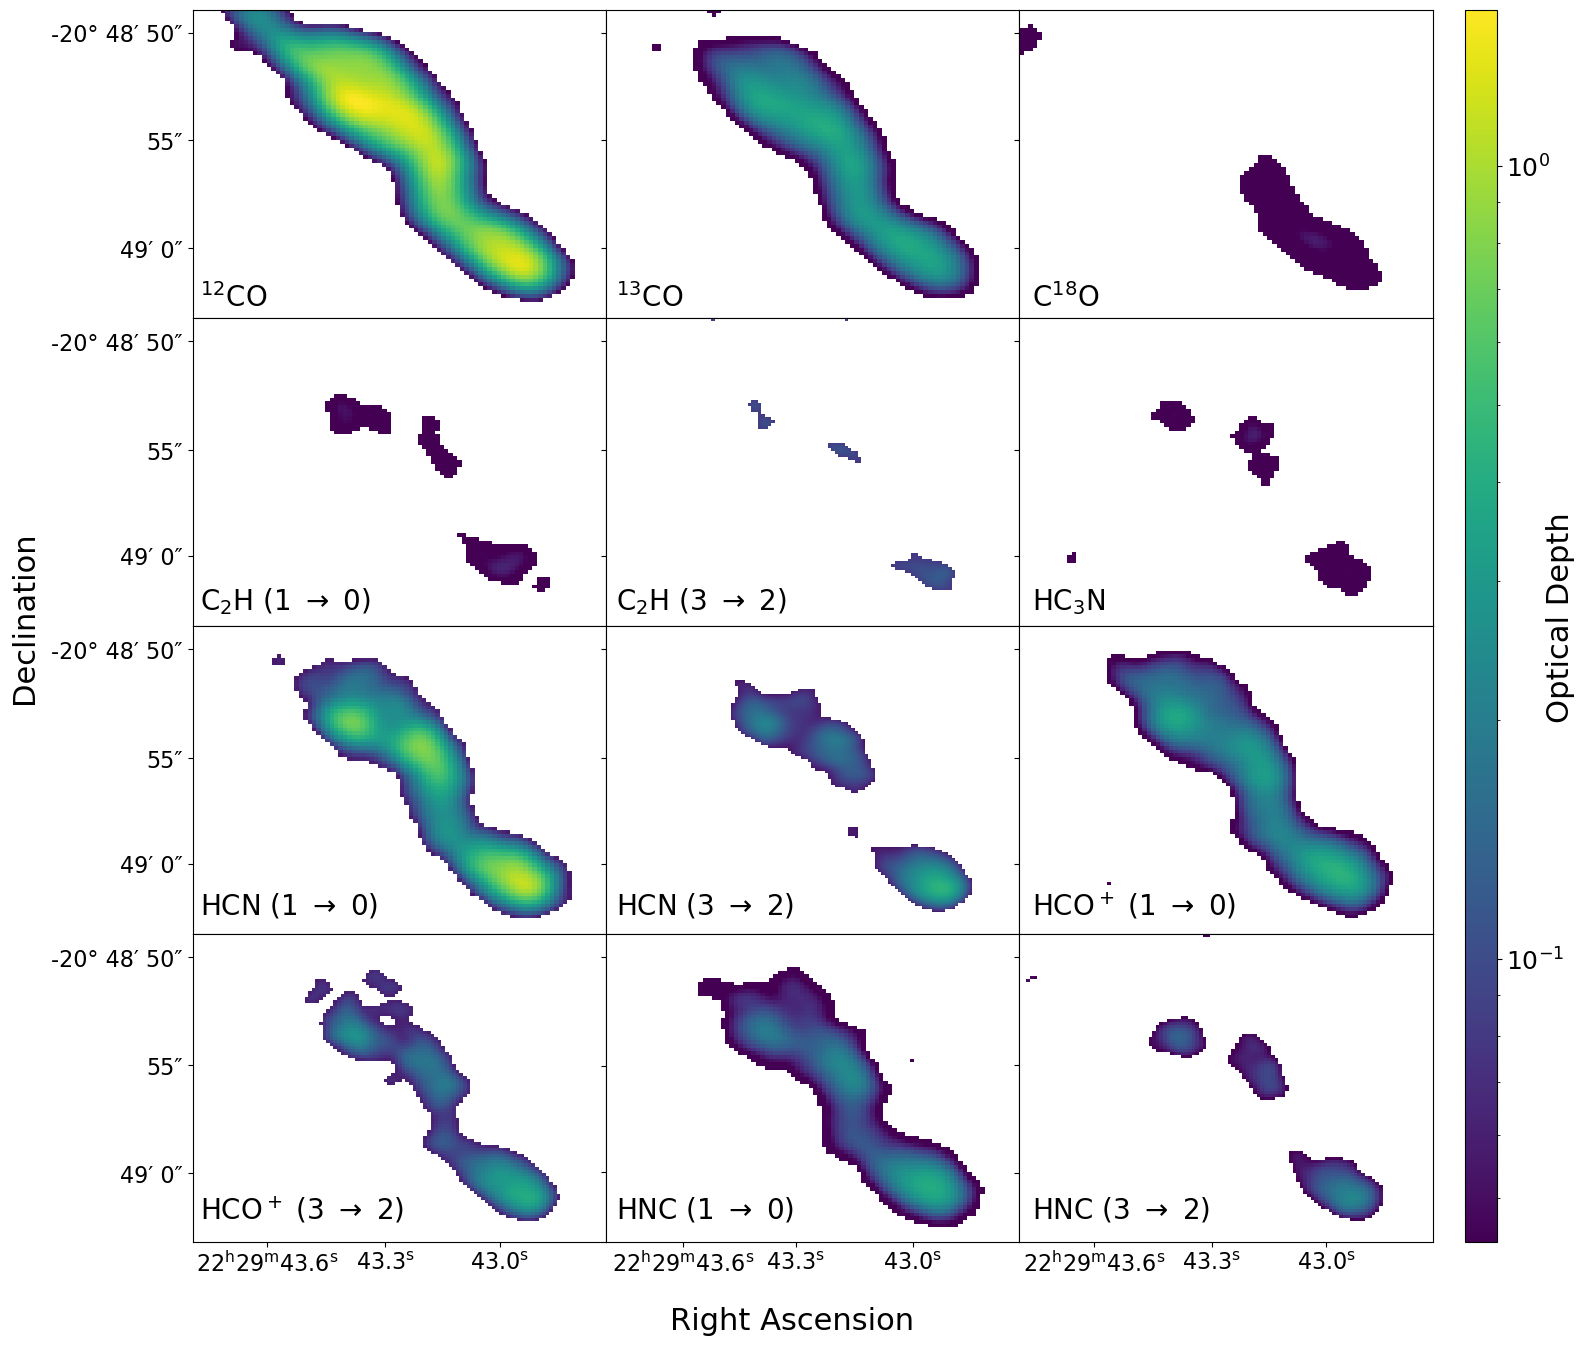

In [4]:
fig = plt.figure(figsize = [16, 16])

extent=[337.43249971, 337.42799971, -20.81756516796, -20.81356516796]

cm1 = plt.cm.get_cmap('viridis')
ax1 = fig.add_subplot(4, 3, 1)
im = ax1.imshow(opt_depth_map(globule = 'GlobB', source = '12CO'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm())

ra_val1 = np.abs(ra_and_dec['12CO'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['12CO'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['12CO'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax1.set_xticks([ra_and_dec['12CO'][0][ra_val1], ra_and_dec['12CO'][0][ra_val2], ra_and_dec['12CO'][0][ra_val3]])
ax1.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['12CO'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['12CO'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['12CO'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax1.set_yticks([ra_and_dec['12CO'][1][dec_val2], ra_and_dec['12CO'][1][dec_val3], ra_and_dec['12CO'][1][dec_val4]])
ax1.set_yticklabels(['49′ 0″','55″','-20° 48′ 50″'], fontsize = 16)
    
#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax2 = fig.add_subplot(4, 3, 2)
ax2.imshow(opt_depth_map(globule = 'GlobB', source = '13CO'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto', 
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))

ra_val1 = np.abs(ra_and_dec['13CO'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['13CO'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['13CO'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax2.set_xticks([ra_and_dec['13CO'][0][ra_val1], ra_and_dec['13CO'][0][ra_val2], ra_and_dec['13CO'][0][ra_val3]])
ax2.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['13CO'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['13CO'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['13CO'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax2.set_yticks([ra_and_dec['13CO'][1][dec_val2], ra_and_dec['13CO'][1][dec_val3], ra_and_dec['13CO'][1][dec_val4]])
ax2.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax3 = fig.add_subplot(4, 3, 3)
ax3.imshow(opt_depth_map(globule = 'GlobB', source = 'C18O'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))

ra_val1 = np.abs(ra_and_dec['C18O'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['C18O'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['C18O'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax3.set_xticks([ra_and_dec['C18O'][0][ra_val1], ra_and_dec['C18O'][0][ra_val2], ra_and_dec['C18O'][0][ra_val3]])
ax3.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['C18O'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['C18O'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['C18O'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax3.set_yticks([ra_and_dec['C18O'][1][dec_val2], ra_and_dec['C18O'][1][dec_val3], ra_and_dec['C18O'][1][dec_val4]])
ax3.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax4 = fig.add_subplot(4, 3, 4)
ax4.imshow(opt_depth_map(globule = 'GlobB', source = 'CCH'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))

ra_val1 = np.abs(ra_and_dec['CCH'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['CCH'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['CCH'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax4.set_xticks([ra_and_dec['CCH'][0][ra_val1], ra_and_dec['CCH'][0][ra_val2], ra_and_dec['CCH'][0][ra_val3]])
ax4.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['CCH'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['CCH'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['CCH'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax4.set_yticks([ra_and_dec['CCH'][1][dec_val2], ra_and_dec['CCH'][1][dec_val3], ra_and_dec['CCH'][1][dec_val4]])
ax4.set_yticklabels(['49′ 0″','55″','-20° 48′ 50″'], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax5 = fig.add_subplot(4, 3, 5)
ax5.imshow(opt_depth_map(globule = 'GlobB', source = 'CCH_32'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))

ra_val1 = np.abs(ra_and_dec['CCH_32'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['CCH_32'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['CCH_32'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax5.set_xticks([ra_and_dec['CCH_32'][0][ra_val1], ra_and_dec['CCH_32'][0][ra_val2], ra_and_dec['CCH_32'][0][ra_val3]])
ax5.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['CCH_32'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['CCH_32'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['CCH_32'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax5.set_yticks([ra_and_dec['CCH_32'][1][dec_val2], ra_and_dec['CCH_32'][1][dec_val3], ra_and_dec['CCH_32'][1][dec_val4]])
ax5.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax6 = fig.add_subplot(4, 3, 6)
ax6.imshow(opt_depth_map(globule = 'GlobB', source = 'HC3N'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))

ra_val1 = np.abs(ra_and_dec['HC3N'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['HC3N'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['HC3N'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax6.set_xticks([ra_and_dec['HC3N'][0][ra_val1], ra_and_dec['HC3N'][0][ra_val2], ra_and_dec['HC3N'][0][ra_val3]])
ax6.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['HC3N'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['HC3N'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['HC3N'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax6.set_yticks([ra_and_dec['HC3N'][1][dec_val2], ra_and_dec['HC3N'][1][dec_val3], ra_and_dec['HC3N'][1][dec_val4]])
ax6.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax7 = fig.add_subplot(4, 3, 7)
ax7.imshow(opt_depth_map(globule = 'GlobB', source = 'HCN'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))

ra_val1 = np.abs(ra_and_dec['HCN'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['HCN'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['HCN'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax7.set_xticks([ra_and_dec['HCN'][0][ra_val1], ra_and_dec['HCN'][0][ra_val2], ra_and_dec['HCN'][0][ra_val3]])
ax7.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['HCN'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['HCN'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['HCN'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax7.set_yticks([ra_and_dec['HCN'][1][dec_val2], ra_and_dec['HCN'][1][dec_val3], ra_and_dec['HCN'][1][dec_val4]])
ax7.set_yticklabels(['49′ 0″','55″','-20° 48′ 50″'], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax8 = fig.add_subplot(4, 3, 8)
ax8.imshow(opt_depth_map(globule = 'GlobB', source = 'HCN_32'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))

ra_val1 = np.abs(ra_and_dec['HCN_32'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['HCN_32'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['HCN_32'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax8.set_xticks([ra_and_dec['HCN_32'][0][ra_val1], ra_and_dec['HCN_32'][0][ra_val2], ra_and_dec['HCN_32'][0][ra_val3]])
ax8.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['HCN_32'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['HCN_32'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['HCN_32'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax8.set_yticks([ra_and_dec['HCN_32'][1][dec_val2], ra_and_dec['HCN_32'][1][dec_val3], ra_and_dec['HCN_32'][1][dec_val4]])
ax8.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax9 = fig.add_subplot(4, 3, 9)
ax9.imshow(opt_depth_map(globule = 'GlobB', source = 'HCOp'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))

ra_val1 = np.abs(ra_and_dec['HCOp'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['HCOp'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['HCOp'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax9.set_xticks([ra_and_dec['HCOp'][0][ra_val1], ra_and_dec['HCOp'][0][ra_val2], ra_and_dec['HCOp'][0][ra_val3]])
ax9.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['HCOp'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['HCOp'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['HCOp'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax9.set_yticks([ra_and_dec['HCOp'][1][dec_val2], ra_and_dec['HCOp'][1][dec_val3], ra_and_dec['HCOp'][1][dec_val4]])
ax9.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax10 = fig.add_subplot(4, 3, 10)
ax10.imshow(opt_depth_map(globule = 'GlobB', source = 'HCOp_32'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))

ra_val1 = np.abs(ra_and_dec['HCOp_32'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['HCOp_32'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['HCOp_32'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax10.set_xticks([ra_and_dec['HCOp_32'][0][ra_val1], ra_and_dec['HCOp_32'][0][ra_val2], ra_and_dec['HCOp_32'][0][ra_val3]])
ax10.set_xticklabels(['$\mathrm{22^{h}29^{m}43.6^{s}}$', '$\mathrm{43.3^{s}}$', '$\mathrm{43.0^{s}}$'], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['HCOp_32'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['HCOp_32'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['HCOp_32'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax10.set_yticks([ra_and_dec['HCOp_32'][1][dec_val2], ra_and_dec['HCOp_32'][1][dec_val3], ra_and_dec['HCOp_32'][1][dec_val4]])
ax10.set_yticklabels(['49′ 0″','55″','-20° 48′ 50″'], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax11 = fig.add_subplot(4, 3, 11)
ax11.imshow(opt_depth_map(globule = 'GlobB', source = 'HNC'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))

ra_val1 = np.abs(ra_and_dec['HNC'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['HNC'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['HNC'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax11.set_xticks([ra_and_dec['HNC'][0][ra_val1], ra_and_dec['HNC'][0][ra_val2], ra_and_dec['HNC'][0][ra_val3]])
ax11.set_xticklabels(['$\mathrm{22^{h}29^{m}43.6^{s}}$', '$\mathrm{43.3^{s}}$', '$\mathrm{43.0^{s}}$'], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['HNC'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['HNC'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['HNC'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax11.set_yticks([ra_and_dec['HNC'][1][dec_val2], ra_and_dec['HNC'][1][dec_val3], ra_and_dec['HNC'][1][dec_val4]])
ax11.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax12 = fig.add_subplot(4, 3, 12)
ax12.imshow(opt_depth_map(globule = 'GlobB', source = 'HNC_32'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))

ra_val1 = np.abs(ra_and_dec['HNC_32'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['HNC_32'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['HNC_32'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax12.set_xticks([ra_and_dec['HNC_32'][0][ra_val1], ra_and_dec['HNC_32'][0][ra_val2], ra_and_dec['HNC_32'][0][ra_val3]])
ax12.set_xticklabels(['$\mathrm{22^{h}29^{m}43.6^{s}}$', '$\mathrm{43.3^{s}}$', '$\mathrm{43.0^{s}}$'], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['HNC_32'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['HNC_32'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['HNC_32'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax12.set_yticks([ra_and_dec['HNC_32'][1][dec_val2], ra_and_dec['HNC_32'][1][dec_val3], ra_and_dec['HNC_32'][1][dec_val4]])
ax12.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

fig.text(0.5, 0.06, 'Right Ascension', fontsize=22, horizontalalignment='center', verticalalignment='center', rotation = 'horizontal')
fig.text(0.02, 0.5, 'Declination', fontsize=22, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')
fig.text(0.98, 0.5, 'Optical Depth', fontsize=22, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')

fig.text(0.13, 0.70, r'$^{12}$CO', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.39, 0.70, r'$^{13}$CO', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.65, 0.70, r'C$^{18}$O', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.13, 0.51, r'C$_2$H (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.39, 0.51, r'C$_2$H (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.65, 0.51, r'HC$_3$N', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.13, 0.32, r'HCN (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.39, 0.32, r'HCN (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.65, 0.32, r'HCO$^+$ (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.13, 0.13, r'HCO$^+$ (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.39, 0.13, r'HNC (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.65, 0.13, r'HNC (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')

cbaxes1 = fig.add_axes([0.92, 0.11, 0.02, 0.77], zorder = 4) 
cbar1 = fig.colorbar(im, cax=cbaxes1, orientation='vertical')

for t in cbar1.ax.get_yticklabels():
    t.set_fontsize(18)

plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout()
plt.savefig('GlobuleB_Optical_Depth_Final.png', bbox_inches='tight')

In [5]:
source_array = ['CCH', 'CCH_32', 'HC3N', 'HCN', 'HCN_32', 'HCOp', 'HCOp_32', 'HNC', 'HNC_32']

ra_lists = []
dec_lists = []
for i in source_array:
    path = 'GlobC_' + i + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header

    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    ra_lists.append(ra)
    dec_lists.append(dec)

ra_and_dec_c = pd.DataFrame({'CCH':[ra_lists[0], dec_lists[0]], 
                          'CCH_32':[ra_lists[1], dec_lists[1]],
                          'HC3N':[ra_lists[2], dec_lists[2]],
                          'HCN':[ra_lists[3], dec_lists[3]],
                          'HCN_32':[ra_lists[4], dec_lists[4]],
                          'HCOp':[ra_lists[5], dec_lists[5]],
                          'HCOp_32':[ra_lists[6], dec_lists[6]],
                          'HNC':[ra_lists[7], dec_lists[7]],
                          'HNC_32':[ra_lists[8], dec_lists[8]]})

display(ra_and_dec_c)

,CCH,CCH_32,HC3N,HCN,HCN_32,HCOp,HCOp_32,HNC,HNC_32
0,"[337.42185105766663, 337.4218038354444, 337.42...","[337.4126832999, 337.4126499665667, 337.412616...","[337.42185105766663, 337.4218038354444, 337.42...","[337.42185105766663, 337.4218038354444, 337.42...","[337.4126832999, 337.4126499665667, 337.412616...","[337.42185105766663, 337.4218038354444, 337.42...","[337.4126835305, 337.41265019716667, 337.41261...","[337.42185105766663, 337.4218038354444, 337.42...","[337.4126835305, 337.41265019716667, 337.41261..."
1,"[-20.813637381216665, -20.813590158994444, -20...","[-20.80447071196, -20.804437378626666, -20.804...","[-20.813637381216665, -20.813590158994444, -20...","[-20.813637381216665, -20.813590158994444, -20...","[-20.80447071196, -20.804437378626666, -20.804...","[-20.813637381216665, -20.813590158994444, -20...","[-20.80447070536, -20.804437372026666, -20.804...","[-20.813637381216665, -20.813590158994444, -20...","[-20.80447070536, -20.804437372026666, -20.804..."


In [6]:
def opt_depth_map_c(globule ='GlobC', source = '12CO'):
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header

    data1 = data[0,:,:,:]
    h = 6.62608e-34
    k = 1.38065e-23

    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)

    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    channels = np.arange(header["NAXIS3"])

    frequency = freq_start + (freq_inc * channels)
    frequency = np.array(frequency, dtype = float)

    freq_start_ghz = header["CRVAL3"]/1e9
    freq_inc_ghz = header["CDELT3"]/1e9
    frequency_ghz = freq_start_ghz + (freq_inc_ghz * channels)
    frequency_ghz = np.array(frequency_ghz, dtype = float)

    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
    #print(vel_inc)
    
    x1 = round(header["CRPIX1"]-(ra_start-337.40975)/ra_inc)-1
    x2 = round(header["CRPIX1"]-(ra_start-337.40565)/ra_inc)-1
    y1 = round(header["CRPIX2"]-(dec_start+20.80087)/dec_inc)-1
    y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1

    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]

    hnu_k = h*frequency[0]/k

    integrated = np.sum(data3[:, :, :], axis = 0)

    max_val = np.nanmax(integrated)

    a = [x for x in range(len(data1[:, 0, 0]))]
    array = []
    for i in range(len(a)):
        if np.nanmax(data3[a[i], :, :]) > d_vals[source][1]*max_val:
            array.append(a[i])
    extent=[ra[x1],ra[x2],dec[y1],dec[y2]]

    moment0 = np.sum(data3[array, :, :], axis = 0)*abs(vel_inc)
    sigma_mask = sigma_clip(moment0, sigma=2.8, maxiters=None, cenfunc='mean')
    newmask = (moment0 < np.amax(sigma_mask))
    mom0 = np.ma.array(moment0, mask = newmask)
    bmaj = header['BMAJ']#major beam width
    bmin = header['BMIN']#minor beam width
    I = np.nanmax(mom0)    
    t_mb = 1.222e3*mom0*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    Tex = 24.96 #Globule C
    den = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb/hnu_k
    almost = 1-den
    opt_depth_map = -np.log(almost) 
    
    return opt_depth_map     

C:\Users\lucys\AppData\Local\Temp\ipykernel_19964\1590105492.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('viridis')


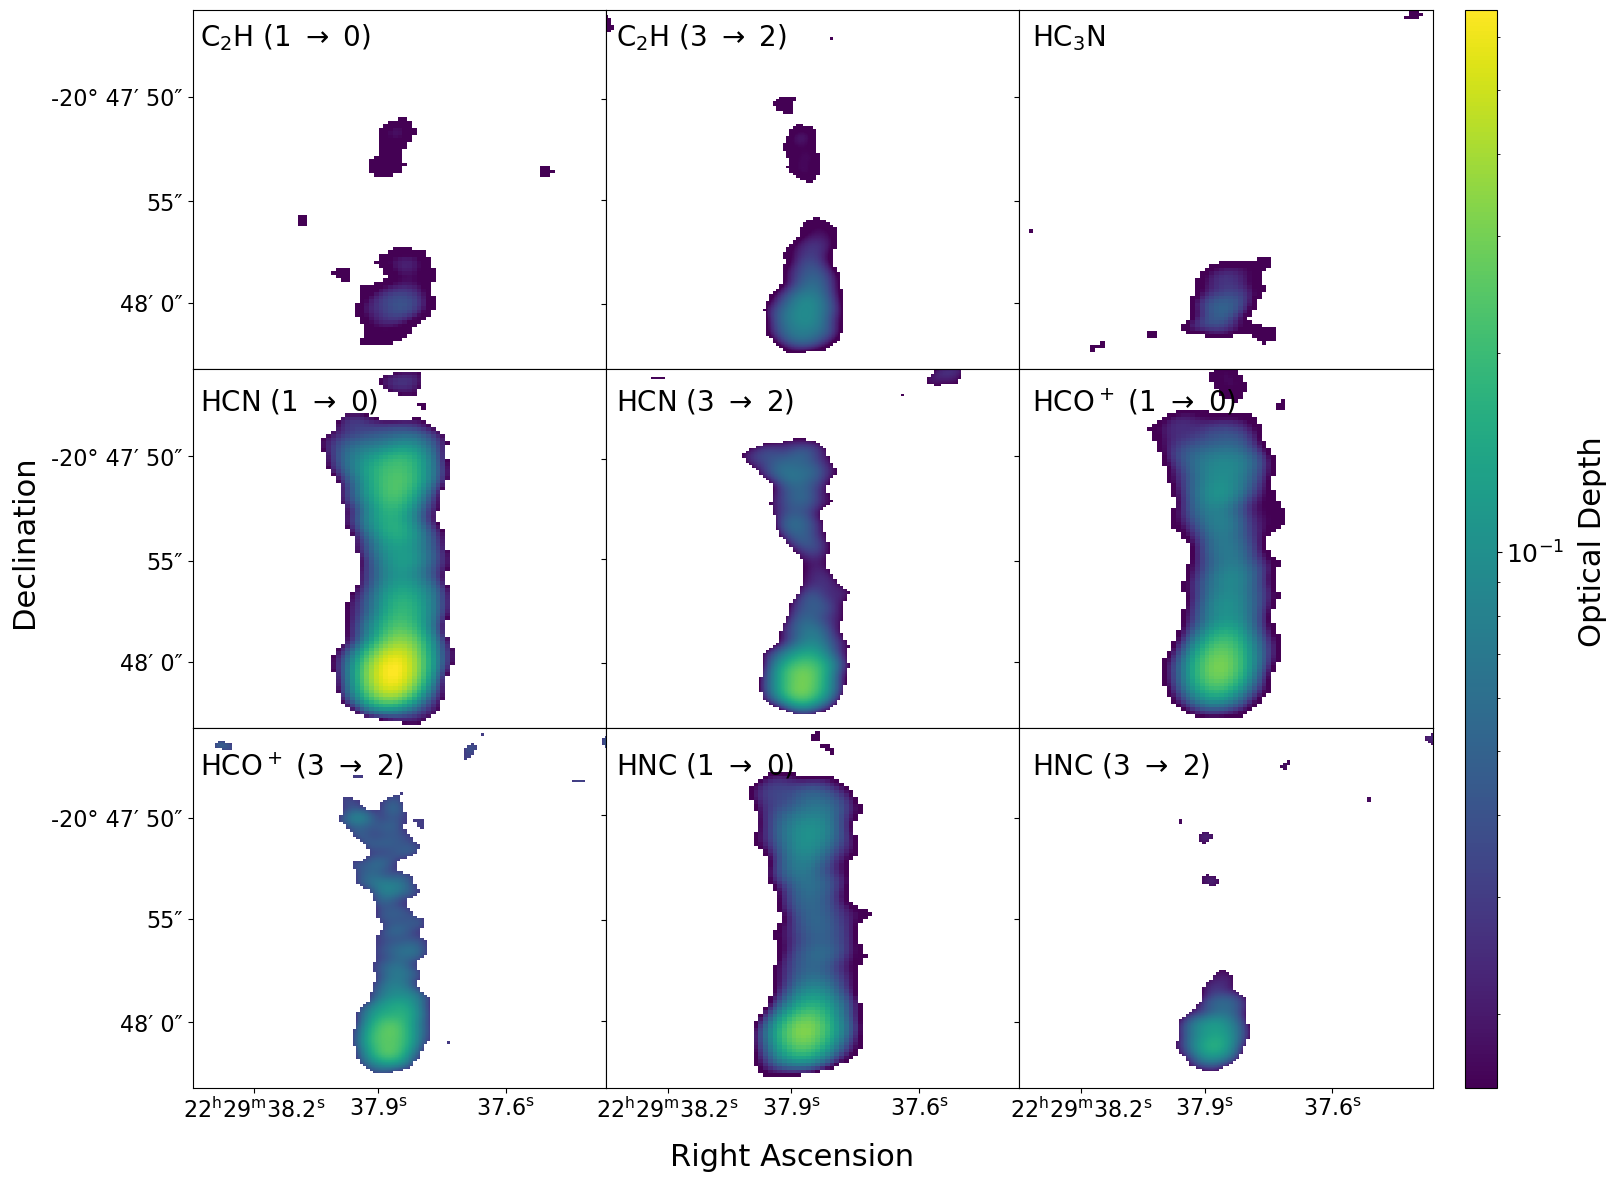

In [7]:
figure = plt.figure(figsize = [16, 14])

extent = [337.4097621687778, 337.4056538354444, -20.80088738121667, -20.79602349232778]

cm1 = plt.cm.get_cmap('viridis')
ax1 = figure.add_subplot(3, 3, 1)
plt.imshow(opt_depth_map_c(globule = 'GlobC', source = 'CCH'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                                   vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['CCH'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['CCH'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['CCH'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax1.set_xticks([ra_and_dec_c['CCH'][0][ra_val1], ra_and_dec_c['CCH'][0][ra_val2], ra_and_dec_c['CCH'][0][ra_val3]])
ax1.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['CCH'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['CCH'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['CCH'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec(source = 'CCH') + 20.8180556).argmin()
ax1.set_yticks([ra_and_dec_c['CCH'][1][dec_val2], ra_and_dec_c['CCH'][1][dec_val3], ra_and_dec_c['CCH'][1][dec_val4]])
ax1.set_yticklabels(['48′ 0″','55″','-20° 47′ 50″'], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax2 = figure.add_subplot(3, 3, 2)
ax2.imshow(opt_depth_map_c(globule = 'GlobC', source = 'CCH_32'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                                   vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['CCH_32'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['CCH_32'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['CCH_32'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax2.set_xticks([ra_and_dec_c['CCH_32'][0][ra_val1], ra_and_dec_c['CCH_32'][0][ra_val2], ra_and_dec_c['CCH_32'][0][ra_val3]])
ax2.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['CCH_32'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['CCH_32'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['CCH_32'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax2.set_yticks([ra_and_dec_c['CCH_32'][1][dec_val2], ra_and_dec_c['CCH_32'][1][dec_val3], ra_and_dec_c['CCH_32'][1][dec_val4]])
ax2.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

ax3 = figure.add_subplot(3, 3, 3)
ax3.imshow(opt_depth_map_c(globule = 'GlobC', source = 'HC3N'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                                   vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['HC3N'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['HC3N'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['HC3N'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax3.set_xticks([ra_and_dec_c['HC3N'][0][ra_val1], ra_and_dec_c['HC3N'][0][ra_val2], ra_and_dec_c['HC3N'][0][ra_val3]])
ax3.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['HC3N'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['HC3N'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['HC3N'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax3.set_yticks([ra_and_dec_c['HC3N'][1][dec_val2], ra_and_dec_c['HC3N'][1][dec_val3], ra_and_dec_c['HC3N'][1][dec_val4]])
ax3.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

ax4 = figure.add_subplot(3, 3, 4)
im = plt.imshow(opt_depth_map_c(globule = 'GlobC', source = 'HCN'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm())

ra_val1 = np.abs(ra_and_dec_c['HCN'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['HCN'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['HCN'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax4.set_xticks([ra_and_dec_c['HCN'][0][ra_val1], ra_and_dec_c['HCN'][0][ra_val2], ra_and_dec_c['HCN'][0][ra_val3]])
ax4.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['HCN'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['HCN'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['HCN'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax4.set_yticks([ra_and_dec_c['HCN'][1][dec_val2], ra_and_dec_c['HCN'][1][dec_val3], ra_and_dec_c['HCN'][1][dec_val4]])
ax4.set_yticklabels(['48′ 0″','55″','-20° 47′ 50″'], fontsize = 16)

#################################################################################################################

ax5 = figure.add_subplot(3, 3, 5)
ax5.imshow(opt_depth_map_c(globule = 'GlobC', source = 'HCN_32'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                                   vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['HCN_32'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['HCN_32'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['HCN_32'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax5.set_xticks([ra_and_dec_c['HCN_32'][0][ra_val1], ra_and_dec_c['HCN_32'][0][ra_val2], ra_and_dec_c['HCN_32'][0][ra_val3]])
ax5.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['HCN_32'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['HCN_32'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['HCN_32'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax5.set_yticks([ra_and_dec_c['HCN_32'][1][dec_val2], ra_and_dec_c['HCN_32'][1][dec_val3], ra_and_dec_c['HCN_32'][1][dec_val4]])
ax5.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

ax6 = figure.add_subplot(3, 3, 6)
ax6.imshow(opt_depth_map_c(globule = 'GlobC', source = 'HCOp'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                                   vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['HCOp'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['HCOp'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['HCOp'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax6.set_xticks([ra_and_dec_c['HCOp'][0][ra_val1], ra_and_dec_c['HCOp'][0][ra_val2], ra_and_dec_c['HCOp'][0][ra_val3]])
ax6.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['HCOp'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['HCOp'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['HCOp'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax6.set_yticks([ra_and_dec_c['HCOp'][1][dec_val2], ra_and_dec_c['HCOp'][1][dec_val3], ra_and_dec_c['HCOp'][1][dec_val4]])
ax6.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

ax7 = figure.add_subplot(3, 3, 7)
ax7.imshow(opt_depth_map_c(globule = 'GlobC', source = 'HCOp_32'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                                   vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['HCOp_32'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['HCOp_32'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['HCOp_32'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax7.set_xticks([ra_and_dec_c['HCOp_32'][0][ra_val1], ra_and_dec_c['HCOp_32'][0][ra_val2], ra_and_dec_c['HCOp_32'][0][ra_val3]])
ax7.set_xticklabels(['$\mathrm{22^{h}29^{m}38.2^{s}}$', '$\mathrm{37.9^{s}}$', '$\mathrm{37.6^{s}}$'], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['HCOp_32'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['HCOp_32'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['HCOp_32'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax7.set_yticks([ra_and_dec_c['HCOp_32'][1][dec_val2], ra_and_dec_c['HCOp_32'][1][dec_val3], ra_and_dec_c['HCOp_32'][1][dec_val4]])
ax7.set_yticklabels(['48′ 0″','55″','-20° 47′ 50″'], fontsize = 16)

#################################################################################################################

ax8 = figure.add_subplot(3, 3, 8)
ax8.imshow(opt_depth_map_c(globule = 'GlobC', source = 'HNC'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                                   vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['HNC'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['HNC'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['HNC'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax8.set_xticks([ra_and_dec_c['HNC'][0][ra_val1], ra_and_dec_c['HNC'][0][ra_val2], ra_and_dec_c['HNC'][0][ra_val3]])
ax8.set_xticklabels(['$\mathrm{22^{h}29^{m}38.2^{s}}$', '$\mathrm{37.9^{s}}$', '$\mathrm{37.6^{s}}$'], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['HNC'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['HNC'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['HNC'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax8.set_yticks([ra_and_dec_c['HNC'][1][dec_val2], ra_and_dec_c['HNC'][1][dec_val3], ra_and_dec_c['HNC'][1][dec_val4]])
ax8.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

ax9 = figure.add_subplot(3, 3, 9)
ax9.imshow(opt_depth_map_c(globule = 'GlobC', source = 'HNC_32'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
           norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                                   vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['HNC_32'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['HNC_32'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['HNC_32'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax9.set_xticks([ra_and_dec_c['HNC_32'][0][ra_val1], ra_and_dec_c['HNC_32'][0][ra_val2], ra_and_dec_c['HNC_32'][0][ra_val3]])
ax9.set_xticklabels(['$\mathrm{22^{h}29^{m}38.2^{s}}$', '$\mathrm{37.9^{s}}$', '$\mathrm{37.6^{s}}$'], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['HNC_32'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['HNC_32'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['HNC_32'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax9.set_yticks([ra_and_dec_c['HNC_32'][1][dec_val2], ra_and_dec_c['HNC_32'][1][dec_val3], ra_and_dec_c['HNC_32'][1][dec_val4]])
ax9.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

figure.text(0.5, 0.06, 'Right Ascension', fontsize=22, horizontalalignment='center', verticalalignment='center', rotation = 'horizontal')
figure.text(0.02, 0.5, 'Declination', fontsize=22, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')
figure.text(1, 0.5, 'Optical Depth', fontsize=22, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')

figure.text(0.13, 0.86, r'C$_2$H (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.39, 0.86, r'C$_2$H (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.65, 0.86, r'HC$_3$N', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.13, 0.60, r'HCN (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.39, 0.60, r'HCN (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.65, 0.60, r'HCO$^+$ (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.13, 0.34, r'HCO$^+$ (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.39, 0.34, r'HNC (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.65, 0.34, r'HNC (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')

cbaxes1 = figure.add_axes([0.92, 0.11, 0.02, 0.77], zorder = 4) 
cbar1 = figure.colorbar(im, cax=cbaxes1, orientation='vertical')

for t in cbar1.ax.get_yticklabels():
    t.set_fontsize(18)

plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout()
plt.savefig('GlobuleC_Optical_Depth_Final.png', bbox_inches='tight')

# Column Density Maps

In [8]:
einstein_coefficients = pd.DataFrame({'12CO':[5.76e10, 7.16e-7, 2],
                                      '13CO':[5.51e10, 6.25e-7, 2],
                                      'C18O':[5.49e10, 6.18e-7, 2], 
                                      'CCH':[4.37e10, 1.65e-6, 1.5],
                                      'CCH_32':[4.37e10, 5.74e-5, 2.5],
                                      'HC3N':[4.55e9, 1.01e-4, 11],
                                      'HCN':[4.43e10, 2.40e-5, 1], 
                                      'HCN_32':[4.43e10, 8.33e-4, 3], 
                                      'HCOp':[4.46e10, 3.00e-5, 1], 
                                      'HCOp_32':[4.46e10, 1.04e-3, 3], 
                                      'HNC':[4.53e10, 2.69e-5, 1], 
                                      'HNC_32':[4.53e10, 9.34e-4, 3]})

def column_density_b(source = '12CO'):
    
    path = 'GlobB_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    data1 = data[0,:,:,:]
    h = 6.62608e-34
    k = 1.38065e-23
    c = 299792458
    pi = math.pi
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    channels = np.arange(header["NAXIS3"])

    frequency = freq_start + (freq_inc * channels)
    frequency = np.array(frequency, dtype = float)
    
    freq_start_ghz = header["CRVAL3"]/1e9
    freq_inc_ghz = header["CDELT3"]/1e9
    frequency_ghz = freq_start_ghz + (freq_inc_ghz * channels)
    frequency_ghz = np.array(frequency_ghz, dtype = float)
    
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000

    x1 = round(header["CRPIX1"]-(ra_start-337.43248)/ra_inc)-1
    x2 = round(header["CRPIX1"]-(ra_start-337.428)/ra_inc)-1
    y1 = round(header["CRPIX2"]-(dec_start+20.8175)/dec_inc)-2
    y2 = round(header["CRPIX2"]-(dec_start+20.81354)/dec_inc)-2
    Tex = 23.94604986

    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]

    hnu_k = h*frequency[0]/k

    integrated = np.sum(data3[:, :, :], axis = 0)

    max_val = np.nanmax(integrated)

    a = [x for x in range(len(data1[:, 0, 0]))]
    array = []
    for i in range(len(a)):
        if np.nanmax(data3[a[i], :, :]) > d_vals[source][0]*max_val:
            array.append(a[i])

    opt_data = data3[array, :, :]

    moment0 = np.nansum(data3[array, :, :], axis = 0)*abs(vel_inc)

    sigma_mask = sigma_clip(moment0, sigma=3, maxiters=None, cenfunc='mean')
    newmask = (moment0 < np.amax(sigma_mask))
    mom0 = np.ma.array(moment0, mask = newmask)
    
    bmaj = header['BMAJ']#major beam width
    bmin = header['BMIN'] #minor beam width
   
    t_mb = 1.222e3*mom0*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    
    X = 1/(np.exp(hnu_k/2.73)-1)
    opt_depth_map = -np.log(1-((1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb/hnu_k))
    
    J = einstein_coefficients[source][2]
    B0 = einstein_coefficients[source][0]
    A_lu = einstein_coefficients[source][1]
    
    Z = (k*Tex)/(h*B0)
    
    term1 = 8*pi*(frequency[0]**2)*k*Z/(h*(c**3)*A_lu)
    term2 = 1/(np.exp(hnu_k/Tex)-1)
    term3 = np.exp(h*B0*J*(J+1)/(k*Tex))
    N_u = term1*term2*term3*opt_depth_map
    
    col_dens = N_u/((2*J)+1)
    
    return col_dens

C:\Users\lucys\AppData\Local\Temp\ipykernel_19964\960254112.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('Reds')
C:\Users\lucys\AppData\Local\Temp\ipykernel_19964\960254112.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm2 = plt.cm.get_cmap('Greens')
C:\Users\lucys\AppData\Local\Temp\ipykernel_19964\960254112.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm3 = plt.cm.get_cmap('Blues')
C:\Users\lucys\AppData\Local\Temp\ipykernel_19964\96

374518930000000.0 1.3401855e+16
544104350000.0 4873832000000.0


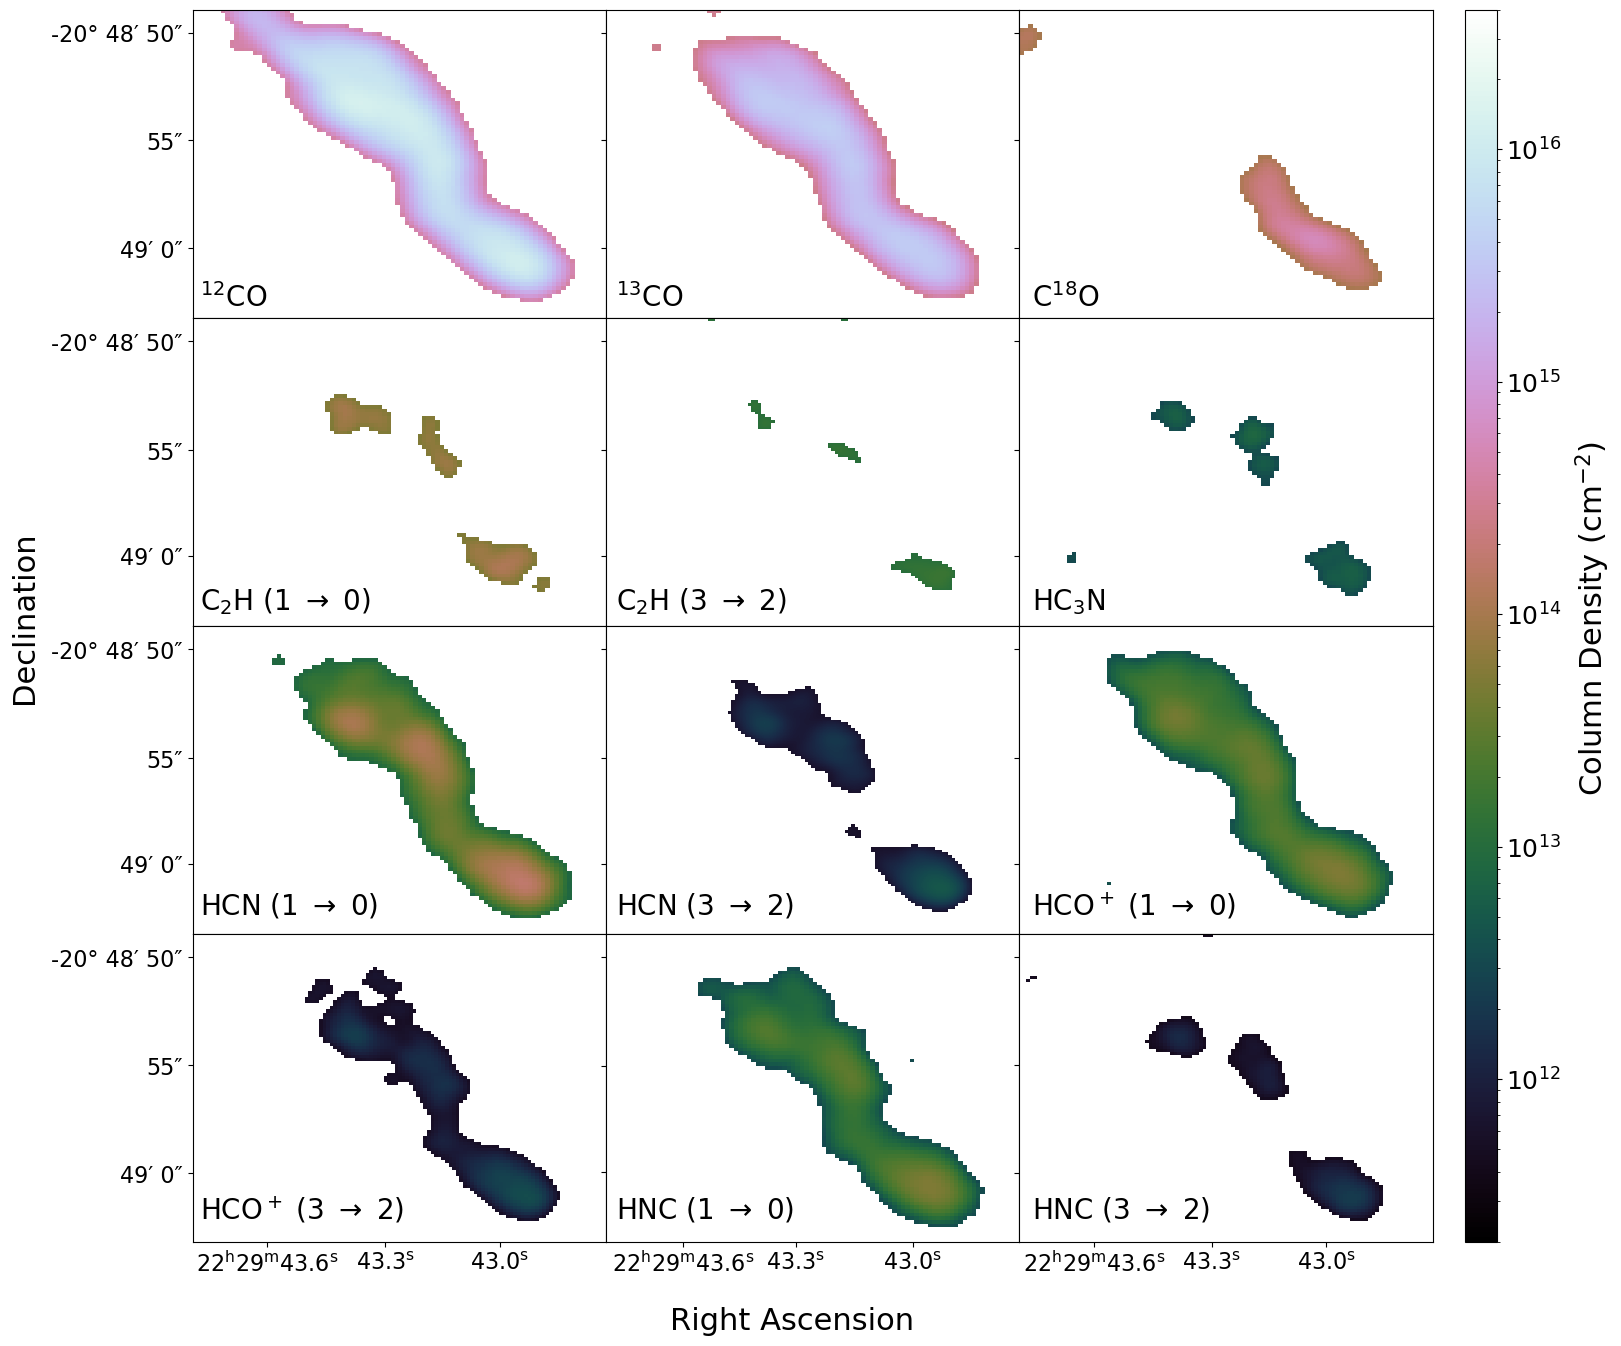

In [20]:
fig = plt.figure(figsize = [16, 16])

extent=[337.43249971, 337.42799971, -20.81756516796, -20.81356516796]

cm1 = plt.cm.get_cmap('Reds')
cm2 = plt.cm.get_cmap('Greens')
cm3 = plt.cm.get_cmap('Blues')

new_cm = plt.cm.get_cmap('cubehelix')

ax1 = fig.add_subplot(4, 3, 1)
im = ax1.imshow(column_density_b(source = '12CO'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto', 
           norm=colors.LogNorm(vmin=2e11, 
                               vmax=4e16))

ra_val1 = np.abs(ra_and_dec['12CO'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['12CO'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['12CO'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax1.set_xticks([ra_and_dec['12CO'][0][ra_val1], ra_and_dec['12CO'][0][ra_val2], ra_and_dec['12CO'][0][ra_val3]])
ax1.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['12CO'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['12CO'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['12CO'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax1.set_yticks([ra_and_dec['12CO'][1][dec_val2], ra_and_dec['12CO'][1][dec_val3], ra_and_dec['12CO'][1][dec_val4]])
ax1.set_yticklabels(['49′ 0″','55″','-20° 48′ 50″'], fontsize = 16)
    
#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax2 = fig.add_subplot(4, 3, 2)
ax2.imshow(column_density_b(source = '13CO'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto', 
          norm=colors.LogNorm(vmin=2e11, 
                              vmax=4e16))

ra_val1 = np.abs(ra_and_dec['13CO'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['13CO'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['13CO'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax2.set_xticks([ra_and_dec['13CO'][0][ra_val1], ra_and_dec['13CO'][0][ra_val2], ra_and_dec['13CO'][0][ra_val3]])
ax2.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['13CO'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['13CO'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['13CO'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax2.set_yticks([ra_and_dec['13CO'][1][dec_val2], ra_and_dec['13CO'][1][dec_val3], ra_and_dec['13CO'][1][dec_val4]])
ax2.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax3 = fig.add_subplot(4, 3, 3)
ax3.imshow(column_density_b(source = 'C18O'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=2e11, 
                              vmax=4e16))

ra_val1 = np.abs(ra_and_dec['C18O'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['C18O'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['C18O'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax3.set_xticks([ra_and_dec['C18O'][0][ra_val1], ra_and_dec['C18O'][0][ra_val2], ra_and_dec['C18O'][0][ra_val3]])
ax3.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['C18O'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['C18O'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['C18O'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax3.set_yticks([ra_and_dec['C18O'][1][dec_val2], ra_and_dec['C18O'][1][dec_val3], ra_and_dec['C18O'][1][dec_val4]])
ax3.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax4 = fig.add_subplot(4, 3, 4)
im2 = ax4.imshow(column_density_b(source = 'CCH'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=2e11, 
                              vmax=4e16))

ra_val1 = np.abs(ra_and_dec['CCH'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['CCH'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['CCH'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax4.set_xticks([ra_and_dec['CCH'][0][ra_val1], ra_and_dec['CCH'][0][ra_val2], ra_and_dec['CCH'][0][ra_val3]])
ax4.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['CCH'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['CCH'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['CCH'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax4.set_yticks([ra_and_dec['CCH'][1][dec_val2], ra_and_dec['CCH'][1][dec_val3], ra_and_dec['CCH'][1][dec_val4]])
ax4.set_yticklabels(['49′ 0″','55″','-20° 48′ 50″'], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax5 = fig.add_subplot(4, 3, 5)
ax5.imshow(column_density_b(source = 'CCH_32'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=2e11, 
                              vmax=4e16))

ra_val1 = np.abs(ra_and_dec['CCH_32'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['CCH_32'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['CCH_32'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax5.set_xticks([ra_and_dec['CCH_32'][0][ra_val1], ra_and_dec['CCH_32'][0][ra_val2], ra_and_dec['CCH_32'][0][ra_val3]])
ax5.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['CCH_32'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['CCH_32'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['CCH_32'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax5.set_yticks([ra_and_dec['CCH_32'][1][dec_val2], ra_and_dec['CCH_32'][1][dec_val3], ra_and_dec['CCH_32'][1][dec_val4]])
ax5.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax6 = fig.add_subplot(4, 3, 6)
ax6.imshow(column_density_b(source = 'HC3N'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=2e11, 
                              vmax=4e16))

ra_val1 = np.abs(ra_and_dec['HC3N'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['HC3N'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['HC3N'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax6.set_xticks([ra_and_dec['HC3N'][0][ra_val1], ra_and_dec['HC3N'][0][ra_val2], ra_and_dec['HC3N'][0][ra_val3]])
ax6.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['HC3N'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['HC3N'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['HC3N'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax6.set_yticks([ra_and_dec['HC3N'][1][dec_val2], ra_and_dec['HC3N'][1][dec_val3], ra_and_dec['HC3N'][1][dec_val4]])
ax6.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax7 = fig.add_subplot(4, 3, 7)
ax7.imshow(column_density_b(source = 'HCN'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=2e11, 
                              vmax=4e16))

ra_val1 = np.abs(ra_and_dec['HCN'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['HCN'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['HCN'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax7.set_xticks([ra_and_dec['HCN'][0][ra_val1], ra_and_dec['HCN'][0][ra_val2], ra_and_dec['HCN'][0][ra_val3]])
ax7.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['HCN'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['HCN'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['HCN'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax7.set_yticks([ra_and_dec['HCN'][1][dec_val2], ra_and_dec['HCN'][1][dec_val3], ra_and_dec['HCN'][1][dec_val4]])
ax7.set_yticklabels(['49′ 0″','55″','-20° 48′ 50″'], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax8 = fig.add_subplot(4, 3, 8)
ax8.imshow(column_density_b(source = 'HCN_32'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=2e11, 
                              vmax=4e16))

ra_val1 = np.abs(ra_and_dec['HCN_32'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['HCN_32'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['HCN_32'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax8.set_xticks([ra_and_dec['HCN_32'][0][ra_val1], ra_and_dec['HCN_32'][0][ra_val2], ra_and_dec['HCN_32'][0][ra_val3]])
ax8.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['HCN_32'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['HCN_32'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['HCN_32'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax8.set_yticks([ra_and_dec['HCN_32'][1][dec_val2], ra_and_dec['HCN_32'][1][dec_val3], ra_and_dec['HCN_32'][1][dec_val4]])
ax8.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax9 = fig.add_subplot(4, 3, 9)
ax9.imshow(column_density_b(source = 'HCOp'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=2e11, 
                              vmax=4e16))

ra_val1 = np.abs(ra_and_dec['HCOp'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['HCOp'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['HCOp'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax9.set_xticks([ra_and_dec['HCOp'][0][ra_val1], ra_and_dec['HCOp'][0][ra_val2], ra_and_dec['HCOp'][0][ra_val3]])
ax9.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['HCOp'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['HCOp'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['HCOp'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax9.set_yticks([ra_and_dec['HCOp'][1][dec_val2], ra_and_dec['HCOp'][1][dec_val3], ra_and_dec['HCOp'][1][dec_val4]])
ax9.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax10 = fig.add_subplot(4, 3, 10)
ax10.imshow(column_density_b(source = 'HCOp_32'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=2e11, 
                              vmax=4e16))

ra_val1 = np.abs(ra_and_dec['HCOp_32'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['HCOp_32'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['HCOp_32'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax10.set_xticks([ra_and_dec['HCOp_32'][0][ra_val1], ra_and_dec['HCOp_32'][0][ra_val2], ra_and_dec['HCOp_32'][0][ra_val3]])
ax10.set_xticklabels(['$\mathrm{22^{h}29^{m}43.6^{s}}$', '$\mathrm{43.3^{s}}$', '$\mathrm{43.0^{s}}$'], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['HCOp_32'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['HCOp_32'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['HCOp_32'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax10.set_yticks([ra_and_dec['HCOp_32'][1][dec_val2], ra_and_dec['HCOp_32'][1][dec_val3], ra_and_dec['HCOp_32'][1][dec_val4]])
ax10.set_yticklabels(['49′ 0″','55″','-20° 48′ 50″'], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax11 = fig.add_subplot(4, 3, 11)
ax11.imshow(column_density_b(source = 'HNC'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=2e11, 
                              vmax=4e16))

ra_val1 = np.abs(ra_and_dec['HNC'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['HNC'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['HNC'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax11.set_xticks([ra_and_dec['HNC'][0][ra_val1], ra_and_dec['HNC'][0][ra_val2], ra_and_dec['HNC'][0][ra_val3]])
ax11.set_xticklabels(['$\mathrm{22^{h}29^{m}43.6^{s}}$', '$\mathrm{43.3^{s}}$', '$\mathrm{43.0^{s}}$'], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['HNC'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['HNC'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['HNC'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax11.set_yticks([ra_and_dec['HNC'][1][dec_val2], ra_and_dec['HNC'][1][dec_val3], ra_and_dec['HNC'][1][dec_val4]])
ax11.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax12 = fig.add_subplot(4, 3, 12)
im3 = ax12.imshow(column_density_b(source = 'HNC_32'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=2e11, 
                              vmax=4e16))

ra_val1 = np.abs(ra_and_dec['HNC_32'][0] - 337.4316667).argmin()
ra_val2 = np.abs(ra_and_dec['HNC_32'][0] - 337.4304167).argmin()
ra_val3 = np.abs(ra_and_dec['HNC_32'][0] - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax12.set_xticks([ra_and_dec['HNC_32'][0][ra_val1], ra_and_dec['HNC_32'][0][ra_val2], ra_and_dec['HNC_32'][0][ra_val3]])
ax12.set_xticklabels(['$\mathrm{22^{h}29^{m}43.6^{s}}$', '$\mathrm{43.3^{s}}$', '$\mathrm{43.0^{s}}$'], fontsize = 16)

dec_val4 = np.abs(ra_and_dec['HNC_32'][1] + 20.8138889).argmin()
dec_val3 = np.abs(ra_and_dec['HNC_32'][1] + 20.8152778).argmin()
dec_val2 = np.abs(ra_and_dec['HNC_32'][1] + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax12.set_yticks([ra_and_dec['HNC_32'][1][dec_val2], ra_and_dec['HNC_32'][1][dec_val3], ra_and_dec['HNC_32'][1][dec_val4]])
ax12.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

fig.text(0.5, 0.06, 'Right Ascension', fontsize=22, horizontalalignment='center', verticalalignment='center', rotation = 'horizontal')
fig.text(0.02, 0.5, 'Declination', fontsize=22, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')
fig.text(1.0, 0.5, r'Column Density (cm$^{-2}$)', fontsize=22, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')

fig.text(0.13, 0.70, r'$^{12}$CO', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.39, 0.70, r'$^{13}$CO', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.65, 0.70, r'C$^{18}$O', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.13, 0.51, r'C$_2$H (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.39, 0.51, r'C$_2$H (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.65, 0.51, r'HC$_3$N', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.13, 0.32, r'HCN (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.39, 0.32, r'HCN (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.65, 0.32, r'HCO$^+$ (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.13, 0.13, r'HCO$^+$ (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.39, 0.13, r'HNC (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.65, 0.13, r'HNC (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')

cbaxes1 = fig.add_axes([0.92, 0.11, 0.02, 0.77], zorder = 4) 
cbar1 = fig.colorbar(im, cax=cbaxes1, orientation='vertical')

for t in cbar1.ax.get_yticklabels():
    t.set_fontsize(18)
    
#cbaxes2 = fig.add_axes([0.92, 0.37, 0.02, 0.25], zorder = 4) 
#cbar2 = fig.colorbar(im2, cax=cbaxes2, orientation='vertical')

#for t in cbar2.ax.get_yticklabels():
    #t.set_fontsize(18)

#cbaxes3 = fig.add_axes([0.92, 0.11, 0.02, 0.25], zorder = 4) 
#cbar3 = fig.colorbar(im3, cax=cbaxes3, orientation='vertical')

#for t in cbar3.ax.get_yticklabels():
    #t.set_fontsize(18)    
    
plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout()
plt.savefig('GlobuleB_Column_Density_Final.png', bbox_inches='tight')

print(np.nanmin(column_density_b(source = '12CO')), np.nanmax(column_density_b(source = '12CO')))
print(np.nanmin(column_density_b(source = 'HCN_32')), np.nanmax(column_density_b(source = 'HCN_32')))

In [22]:
def column_density_c(globule = 'GlobC', source = '12CO'):
    
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    data1 = data[0,:,:,:]
    h = 6.62608e-34
    k = 1.38065e-23
    c = 299792458
    pi = math.pi
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    channels = np.arange(header["NAXIS3"])

    frequency = freq_start + (freq_inc * channels)
    frequency = np.array(frequency, dtype = float)
    
    freq_start_ghz = header["CRVAL3"]/1e9
    freq_inc_ghz = header["CDELT3"]/1e9
    frequency_ghz = freq_start_ghz + (freq_inc_ghz * channels)
    frequency_ghz = np.array(frequency_ghz, dtype = float)
    
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
    
    x1 = round(header["CRPIX1"]-(ra_start-337.40975)/ra_inc)-1
    x2 = round(header["CRPIX1"]-(ra_start-337.40565)/ra_inc)-1
    y1 = round(header["CRPIX2"]-(dec_start+20.80087)/dec_inc)-1
    y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1
    #print(x1, x2, y1, y2)
    Tex = 24.96
    
    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]

    hnu_k = h*frequency[0]/k
    #print(hnu_k)

    integrated = np.sum(data3[:, :, :], axis = 0)

    max_val = np.nanmax(integrated)

    a = [x for x in range(len(data1[:, 0, 0]))]
    array = []
    for i in range(len(a)):
        if np.nanmax(data3[a[i], :, :]) > d_vals[source][0]*max_val:
            array.append(a[i])

    opt_data = data3[array, :, :]

    moment0 = np.nansum(data3[array, :, :], axis = 0)*abs(vel_inc)

    sigma_mask = sigma_clip(moment0, sigma=3, maxiters=None, cenfunc='mean')
    newmask = (moment0 < np.amax(sigma_mask))
    mom0 = np.ma.array(moment0, mask = newmask)

    extent=[ra[x1],ra[x2],dec[y1],dec[y2]]
    
    bmaj = header['BMAJ']#major beam width
    bmin = header['BMIN'] #minor beam width

    t_mb = 1.222e3*mom0*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    
    X = 1/(np.exp(hnu_k/2.73)-1)
    opt_depth_map = -np.log(1-((1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb/hnu_k))

    J = einstein_coefficients[source][2]
    B0 = einstein_coefficients[source][0]
    A_lu = einstein_coefficients[source][1]
    
    Z = (k*Tex)/(h*B0)
    
    term1 = 8*pi*(frequency[0]**2)*k*Z/(h*(c**3)*A_lu)
    term2 = 1/(np.exp(hnu_k/Tex)-1)
    term3 = np.exp(h*B0*J*(J+1)/(k*Tex))
    N_u = term1*term2*term3*opt_depth_map
    
    col_dens = N_u/((2*J)+1)
    
    return col_dens

C:\Users\lucys\AppData\Local\Temp\ipykernel_19964\2160442078.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('Greens')
C:\Users\lucys\AppData\Local\Temp\ipykernel_19964\2160442078.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm2 = plt.cm.get_cmap('Blues')
C:\Users\lucys\AppData\Local\Temp\ipykernel_19964\2160442078.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  new_cm = plt.cm.get_cmap('cubehelix')


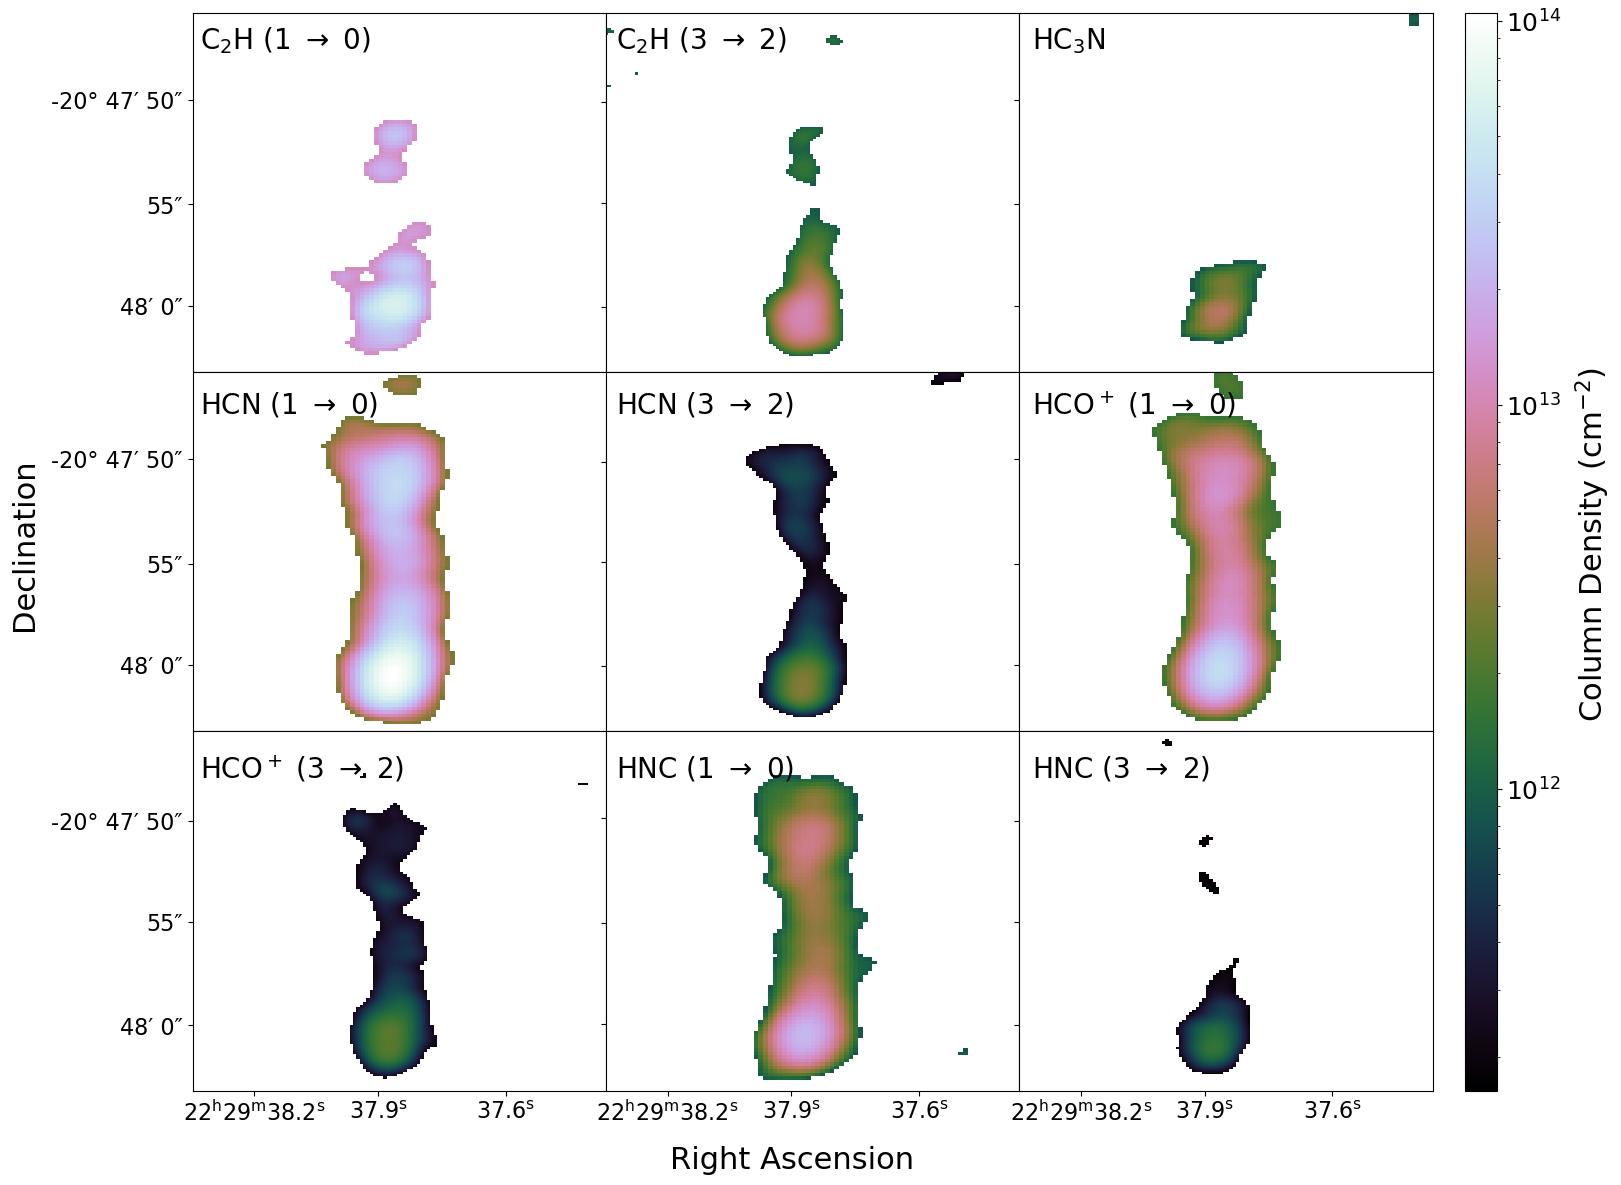

In [25]:
figure = plt.figure(figsize = [16, 14])

extent = [337.4097621687778, 337.4056538354444, -20.80088738121667, -20.79602349232778]

cm1 = plt.cm.get_cmap('Greens')
cm2 = plt.cm.get_cmap('Blues')

new_cm = plt.cm.get_cmap('cubehelix')

ax1 = figure.add_subplot(3, 3, 1)
plt.imshow(column_density_c(source = 'CCH'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(column_density_c(source = 'HNC_32')), 
                                   vmax=np.nanmax(column_density_c(source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['CCH'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['CCH'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['CCH'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax1.set_xticks([ra_and_dec_c['CCH'][0][ra_val1], ra_and_dec_c['CCH'][0][ra_val2], ra_and_dec_c['CCH'][0][ra_val3]])
ax1.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['CCH'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['CCH'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['CCH'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec(source = 'CCH') + 20.8180556).argmin()
ax1.set_yticks([ra_and_dec_c['CCH'][1][dec_val2], ra_and_dec_c['CCH'][1][dec_val3], ra_and_dec_c['CCH'][1][dec_val4]])
ax1.set_yticklabels(['48′ 0″','55″','-20° 47′ 50″'], fontsize = 16)

#################################################################################################################

#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax2 = figure.add_subplot(3, 3, 2)
ax2.imshow(column_density_c(source = 'CCH_32'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(column_density_c(source = 'HNC_32')), 
                                   vmax=np.nanmax(column_density_c(source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['CCH_32'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['CCH_32'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['CCH_32'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax2.set_xticks([ra_and_dec_c['CCH_32'][0][ra_val1], ra_and_dec_c['CCH_32'][0][ra_val2], ra_and_dec_c['CCH_32'][0][ra_val3]])
ax2.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['CCH_32'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['CCH_32'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['CCH_32'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax2.set_yticks([ra_and_dec_c['CCH_32'][1][dec_val2], ra_and_dec_c['CCH_32'][1][dec_val3], ra_and_dec_c['CCH_32'][1][dec_val4]])
ax2.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

ax3 = figure.add_subplot(3, 3, 3)
ax3.imshow(column_density_c(source = 'HC3N'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(column_density_c(source = 'HNC_32')), 
                                   vmax=np.nanmax(column_density_c(source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['HC3N'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['HC3N'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['HC3N'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax3.set_xticks([ra_and_dec_c['HC3N'][0][ra_val1], ra_and_dec_c['HC3N'][0][ra_val2], ra_and_dec_c['HC3N'][0][ra_val3]])
ax3.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['HC3N'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['HC3N'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['HC3N'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax3.set_yticks([ra_and_dec_c['HC3N'][1][dec_val2], ra_and_dec_c['HC3N'][1][dec_val3], ra_and_dec_c['HC3N'][1][dec_val4]])
ax3.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

ax4 = figure.add_subplot(3, 3, 4)
im = plt.imshow(column_density_c(source = 'HCN'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(column_density_c(source = 'HNC_32')), 
                                   vmax=np.nanmax(column_density_c(source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['HCN'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['HCN'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['HCN'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax4.set_xticks([ra_and_dec_c['HCN'][0][ra_val1], ra_and_dec_c['HCN'][0][ra_val2], ra_and_dec_c['HCN'][0][ra_val3]])
ax4.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['HCN'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['HCN'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['HCN'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax4.set_yticks([ra_and_dec_c['HCN'][1][dec_val2], ra_and_dec_c['HCN'][1][dec_val3], ra_and_dec_c['HCN'][1][dec_val4]])
ax4.set_yticklabels(['48′ 0″','55″','-20° 47′ 50″'], fontsize = 16)

#################################################################################################################

ax5 = figure.add_subplot(3, 3, 5)
ax5.imshow(column_density_c(source = 'HCN_32'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(column_density_c(source = 'HNC_32')), 
                                   vmax=np.nanmax(column_density_c(source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['HCN_32'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['HCN_32'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['HCN_32'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax5.set_xticks([ra_and_dec_c['HCN_32'][0][ra_val1], ra_and_dec_c['HCN_32'][0][ra_val2], ra_and_dec_c['HCN_32'][0][ra_val3]])
ax5.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['HCN_32'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['HCN_32'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['HCN_32'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax5.set_yticks([ra_and_dec_c['HCN_32'][1][dec_val2], ra_and_dec_c['HCN_32'][1][dec_val3], ra_and_dec_c['HCN_32'][1][dec_val4]])
ax5.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

ax6 = figure.add_subplot(3, 3, 6)
ax6.imshow(column_density_c(source = 'HCOp'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(column_density_c(source = 'HNC_32')), 
                                   vmax=np.nanmax(column_density_c(source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['HCOp'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['HCOp'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['HCOp'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax6.set_xticks([ra_and_dec_c['HCOp'][0][ra_val1], ra_and_dec_c['HCOp'][0][ra_val2], ra_and_dec_c['HCOp'][0][ra_val3]])
ax6.set_xticklabels([' ', ' ', ' '], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['HCOp'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['HCOp'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['HCOp'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax6.set_yticks([ra_and_dec_c['HCOp'][1][dec_val2], ra_and_dec_c['HCOp'][1][dec_val3], ra_and_dec_c['HCOp'][1][dec_val4]])
ax6.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

ax7 = figure.add_subplot(3, 3, 7)
ax7.imshow(column_density_c(source = 'HCOp_32'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(column_density_c(source = 'HNC_32')), 
                                   vmax=np.nanmax(column_density_c(source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['HCOp_32'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['HCOp_32'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['HCOp_32'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax7.set_xticks([ra_and_dec_c['HCOp_32'][0][ra_val1], ra_and_dec_c['HCOp_32'][0][ra_val2], ra_and_dec_c['HCOp_32'][0][ra_val3]])
ax7.set_xticklabels(['$\mathrm{22^{h}29^{m}38.2^{s}}$', '$\mathrm{37.9^{s}}$', '$\mathrm{37.6^{s}}$'], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['HCOp_32'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['HCOp_32'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['HCOp_32'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax7.set_yticks([ra_and_dec_c['HCOp_32'][1][dec_val2], ra_and_dec_c['HCOp_32'][1][dec_val3], ra_and_dec_c['HCOp_32'][1][dec_val4]])
ax7.set_yticklabels(['48′ 0″','55″','-20° 47′ 50″'], fontsize = 16)

#################################################################################################################

ax8 = figure.add_subplot(3, 3, 8)
ax8.imshow(column_density_c(source = 'HNC'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm(vmin=np.nanmin(column_density_c(source = 'HNC_32')), 
                                   vmax=np.nanmax(column_density_c(source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['HNC'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['HNC'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['HNC'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax8.set_xticks([ra_and_dec_c['HNC'][0][ra_val1], ra_and_dec_c['HNC'][0][ra_val2], ra_and_dec_c['HNC'][0][ra_val3]])
ax8.set_xticklabels(['$\mathrm{22^{h}29^{m}38.2^{s}}$', '$\mathrm{37.9^{s}}$', '$\mathrm{37.6^{s}}$'], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['HNC'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['HNC'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['HNC'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax8.set_yticks([ra_and_dec_c['HNC'][1][dec_val2], ra_and_dec_c['HNC'][1][dec_val3], ra_and_dec_c['HNC'][1][dec_val4]])
ax8.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

ax9 = figure.add_subplot(3, 3, 9)
im2 = ax9.imshow(column_density_c(source = 'HNC_32'), origin='lower', cmap=new_cm, extent = extent, aspect = 'auto',
           norm=mpl.colors.LogNorm(vmin=np.nanmin(column_density_c(source = 'HNC_32')), 
                                   vmax=np.nanmax(column_density_c(source = 'HCN'))))

ra_val1 = np.abs(ra_and_dec_c['HNC_32'][0] - 337.4091667 ).argmin()
ra_val2 = np.abs(ra_and_dec_c['HNC_32'][0] - 337.4079167).argmin()
ra_val3 = np.abs(ra_and_dec_c['HNC_32'][0] - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax9.set_xticks([ra_and_dec_c['HNC_32'][0][ra_val1], ra_and_dec_c['HNC_32'][0][ra_val2], ra_and_dec_c['HNC_32'][0][ra_val3]])
ax9.set_xticklabels(['$\mathrm{22^{h}29^{m}38.2^{s}}$', '$\mathrm{37.9^{s}}$', '$\mathrm{37.6^{s}}$'], fontsize = 16)

dec_val4 = np.abs(ra_and_dec_c['HNC_32'][1] + 20.7972222).argmin()
dec_val3 = np.abs(ra_and_dec_c['HNC_32'][1] + 20.7986111).argmin()
dec_val2 = np.abs(ra_and_dec_c['HNC_32'][1] + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax9.set_yticks([ra_and_dec_c['HNC_32'][1][dec_val2], ra_and_dec_c['HNC_32'][1][dec_val3], ra_and_dec_c['HNC_32'][1][dec_val4]])
ax9.set_yticklabels([' ',' ',' '], fontsize = 16)

#################################################################################################################

figure.text(0.5, 0.06, 'Right Ascension', fontsize=22, horizontalalignment='center', verticalalignment='center', rotation = 'horizontal')
figure.text(0.02, 0.5, 'Declination', fontsize=22, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')
figure.text(1, 0.5, r'Column Density (cm$^{-2}$)', fontsize=22, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')

figure.text(0.13, 0.86, r'C$_2$H (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.39, 0.86, r'C$_2$H (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.65, 0.86, r'HC$_3$N', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.13, 0.60, r'HCN (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.39, 0.60, r'HCN (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.65, 0.60, r'HCO$^+$ (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.13, 0.34, r'HCO$^+$ (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.39, 0.34, r'HNC (1 $\rightarrow$ 0)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.65, 0.34, r'HNC (3 $\rightarrow$ 2)', fontsize=20, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')

cbaxes1 = figure.add_axes([0.92, 0.11, 0.02, 0.77], zorder = 4) 
cbar1 = figure.colorbar(im, cax=cbaxes1, orientation='vertical')

for t in cbar1.ax.get_yticklabels():
    t.set_fontsize(18)
    
#cbaxes2 = figure.add_axes([0.92, 0.11, 0.02, 0.38], zorder = 4) 
#cbar2 = figure.colorbar(im2, cax=cbaxes2, orientation='vertical')

#for t in cbar2.ax.get_yticklabels():
    #t.set_fontsize(18)

plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout()
plt.savefig('GlobuleC_Column_Density_Final.png', bbox_inches='tight')

In [16]:
def avg_column_density(globule = 'GlobB', source = '12CO'):
    
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    data1 = data[0,:,:,:]
    h = 6.62608e-34
    k = 1.38065e-23
    c = 299792458
    pi = math.pi
    figure = plt.figure(figsize=[10,10]) #Globule B
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    channels = np.arange(header["NAXIS3"])

    frequency = freq_start + (freq_inc * channels)
    frequency = np.array(frequency, dtype = float)
    
    freq_start_ghz = header["CRVAL3"]/1e9
    freq_inc_ghz = header["CDELT3"]/1e9
    frequency_ghz = freq_start_ghz + (freq_inc_ghz * channels)
    frequency_ghz = np.array(frequency_ghz, dtype = float)
    
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
    
    if globule == 'GlobB':
        x_1 = round(header["CRPIX1"]-(ra_start-337.433)/ra_inc)-1 
        x_2 = round(header["CRPIX1"]-(ra_start-337.427)/ra_inc)-1
        x1 = round(header["CRPIX1"]-(ra_start-337.4289)/ra_inc)-1 
        x2 = round(header["CRPIX1"]-(ra_start-337.4297)/ra_inc)-1 
        x3 = round(header["CRPIX1"]-(ra_start-337.4300)/ra_inc)-1
        x4 = round(header["CRPIX1"]-(ra_start-337.4308)/ra_inc)-1
        x5 = round(header["CRPIX2"]-(ra_start-337.4301)/ra_inc)-1
        x6 = round(header["CRPIX2"]-(ra_start-337.4322)/ra_inc)-1
        
        y_1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-2
        y_2 = round(header["CRPIX2"]-(dec_start+20.814)/dec_inc)-2 
        y1 = round(header["CRPIX2"]-(dec_start+20.8169)/dec_inc)-1
        y2 = round(header["CRPIX2"]-(dec_start+20.8162)/dec_inc)-1
        y3 = round(header["CRPIX2"]-(dec_start+20.8152)/dec_inc)-1
        y4 = round(header["CRPIX2"]-(dec_start+20.8149)/dec_inc)-1
        y5 = round(header["CRPIX2"]-(dec_start+20.8123)/dec_inc)-1
        y6 = round(header["CRPIX2"]-(dec_start+20.8130)/dec_inc)-1
        Tex = 23.94604986
    elif globule == 'GlobC':
        x_1 = round(header["CRPIX1"]-(ra_start-337.409)/ra_inc)-1 
        x_2 = round(header["CRPIX1"]-(ra_start-337.406)/ra_inc)-1 
        x1 = round(header["CRPIX1"]-(ra_start-337.4078)/ra_inc)-1 
        x2 = round(header["CRPIX1"]-(ra_start-337.4078)/ra_inc)-1
        x3 = round(header["CRPIX1"]-(ra_start-337.4076)/ra_inc)-1
        y_1 = round(header["CRPIX2"]-(dec_start+20.801)/dec_inc)-1
        y_2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.8001)/dec_inc)-1
        y2 = round(header["CRPIX2"]-(dec_start+20.7976)/dec_inc)-1
        y3 = round(header["CRPIX2"]-(dec_start+20.7971)/dec_inc)-1
        Tex = 24.96
    
    box = 6
    data2 = data1[:, :, np.arange(x_1, x_2)]
    data3 = data2[:, np.arange(y_1, y_2), :]
    
    data2_1 = data1[:, :, np.arange(x1-box, x1+box)]
    data3_1 = data2_1[:, np.arange(y1-box, y1+box), :]
    
    data2_2 = data1[:, :, np.arange(x2-box, x2+box)]
    data3_2 = data2_2[:, np.arange(y2-box, y2+box), :]
    
    data2_3 = data1[:, :, np.arange(x3-box, x3+box)]
    data3_3 = data2_3[:, np.arange(y3-box, y3+box), :]
    
    data2_4 = data1[:, :, np.arange(x4-box, x4+box)]
    data3_4 = data2_4[:, np.arange(y4-box, y4+box), :]
    
    data2_5 = data1[:, :, np.arange(x5-box, x5+box)]
    data3_5 = data2_5[:, np.arange(y5-box, y5+box), :]
    
    data2_6 = data1[:, :, np.arange(x6-box, x6+box)]
    data3_6 = data2_6[:, np.arange(y6-box, y6+box), :]


    if source == '12CO':
        B0 = 5.76e10
        A_lu = 7.16e-7
        r = 5
        b = 5
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.03
    elif source == '13CO':
        B0 = 5.51e10
        A_lu = 6.25e-7
        r = 5
        b = 5
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.1
    elif source == 'C18O':
        B0 = 5.49e10
        A_lu = 6.18e-7
        r = 5
        b = 5
        if globule == 'GlobB':
            d = 0.28
        else:
            d = 0.15
    elif source == 'CCH':
        B0 = 4.37e10
        A_lu = 1.65e-6
        r = 2
        b = 2
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.15
    elif source == 'CCH_32':
        B0 = 4.37e10
        A_lu = 5.74e-5
        r = 7
        b = 12
        if globule == 'GlobB':
            d = 0.15
        else:
            d = 0.08
    elif source == 'HC3N':
        B0 = 4.55e9
        A_lu = 1.01e-4
        r = 25
        b = 156
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.25
    elif source == 'HCN':
        B0 = 4.43e10
        A_lu = 2.40e-5
        r = 2
        b = 2
        if globule == 'GlobB':
            d = 0.06
        else:
            d = 0.08
    elif source == 'HCN_32':
        B0 = 4.43e10
        A_lu = 8.33e-4
        r = 7
        b = 12
        if globule == 'GlobB':
            d = 0.065
        else:
            d = 0.04
    elif source == 'HCOp':
        B0 = 4.46e10
        A_lu = 3.00e-5
        r = 2
        b = 2
        if globule == 'GlobB':
            d = 0.08
        else:
            d = 0.1
    elif source == 'HCOp_32':
        B0 = 4.46e10
        A_lu = 1.04e-3
        r = 7
        b = 12
        if globule == 'GlobB':
            d = 0.1
        else:
            d = 0.08
    elif source == 'HNC':
        B0 = 4.53e10
        A_lu = 2.69e-5
        r = 2
        b = 2
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.08
    elif source == 'HNC_32':
        B0 = 4.53e10
        A_lu = 9.34e-4
        r = 7
        b = 12
        if globule == 'GlobB':
            d = 0.2
        else:
            d = 0.12

    hnu_k = h*frequency[0]/k
    #print(hnu_k)

    integrated = np.sum(data3[:, :, :], axis = 0)

    max_val = np.nanmax(integrated)
    print(max_val)
            
    a = [x for x in range(len(data1[:, 0, 0]))]
    array = []
    for i in range(len(a)):
        if np.nanmax(data3[a[i], :, :]) > d*max_val:
            array.append(a[i])
    print(array)

    moment0_1 = np.sum(data3_1[array, :, :], axis = 0)*abs(vel_inc)
    moment0_2 = np.sum(data3_2[array, :, :], axis = 0)*abs(vel_inc)
    moment0_3 = np.sum(data3_3[array, :, :], axis = 0)*abs(vel_inc)
    moment0_4 = np.sum(data3_4[array, :, :], axis = 0)*abs(vel_inc)
    moment0_5 = np.sum(data3_5[array, :, :], axis = 0)*abs(vel_inc)
    moment0_6 = np.sum(data3_6[array, :, :], axis = 0)*abs(vel_inc)

    I_1 = np.nanmax(moment0_1)    
    t_mb_1 = 1.222e3*moment0_1*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    den_1 = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb_1/hnu_k
    almost_1 = 1-den_1
    opt_depth_map_1 = -np.log(almost_1)

    Z = (k*Tex)/(h*B0)+(1/3)

    mu_lu = np.sqrt((A_lu*3*h*(c**3))/(64*(pi**4)*(frequency[0]**3)))
    term1 = 3*h/(8*pi**3*mu_lu**2)
    Y = np.exp(hnu_k/Tex)-1
    N_u_1 = Y*term1*opt_depth_map_1
    col_dens_1 = N_u_1*Z/r*np.exp(h*B0*b/(k*Tex))
    
    I_2 = np.nanmax(moment0_2)    
    t_mb_2 = 1.222e3*moment0_2*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    den_2 = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb_2/hnu_k
    almost_2 = 1-den_2
    opt_depth_map_2 = -np.log(almost_2)

    Z = (k*Tex)/(h*B0)+(1/3)

    mu_lu = np.sqrt((A_lu*3*h*(c**3))/(64*(pi**4)*(frequency[0]**3)))
    term1 = 3*h/(8*pi**3*mu_lu**2)
    Y = np.exp(hnu_k/Tex)-1
    N_u_2 = Y*term1*opt_depth_map_2
    col_dens_2 = N_u_2*Z/r*np.exp(h*B0*b/(k*Tex))
    
    I_3 = np.nanmax(moment0_3)    
    t_mb_3 = 1.222e3*moment0_3*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    den_3 = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb_3/hnu_k
    almost_3 = 1-den_3
    opt_depth_map_3 = -np.log(almost_3)

    Z = (k*Tex)/(h*B0)+(1/3)

    mu_lu = np.sqrt((A_lu*3*h*(c**3))/(64*(pi**4)*(frequency[0]**3)))
    term1 = 3*h/(8*pi**3*mu_lu**2)
    Y = np.exp(hnu_k/Tex)-1
    N_u_3 = Y*term1*opt_depth_map_3
    col_dens_3 = N_u_3*Z/r*np.exp(h*B0*b/(k*Tex))
    
    I_4 = np.nanmax(moment0_4)    
    t_mb_4 = 1.222e3*moment0_4*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    den_4 = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb_4/hnu_k
    almost_4 = 1-den_4
    opt_depth_map_4 = -np.log(almost_4)

    Z = (k*Tex)/(h*B0)+(1/3)
    mu_lu = np.sqrt((A_lu*3*h*(c**3))/(64*(pi**4)*(frequency[0]**3)))
    term1 = 3*h/(8*pi**3*mu_lu**2)
    Y = np.exp(hnu_k/Tex)-1
    N_u_4 = Y*term1*opt_depth_map_4
    col_dens_4 = N_u_4*Z/r*np.exp(h*B0*b/(k*Tex))
    
    I_5 = np.nanmax(moment0_5)    
    t_mb_5 = 1.222e3*moment0_5*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    den_5 = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb_5/hnu_k
    almost_5 = 1-den_5
    opt_depth_map_5 = -np.log(almost_5)

    Z = (k*Tex)/(h*B0)+(1/3)

    mu_lu = np.sqrt((A_lu*3*h*(c**3))/(64*(pi**4)*(frequency[0]**3)))
    term1 = 3*h/(8*pi**3*mu_lu**2)
    Y = np.exp(hnu_k/Tex)-1
    N_u_5 = Y*term1*opt_depth_map_5
    col_dens_5 = N_u_5*Z/r*np.exp(h*B0*b/(k*Tex))
    
    I_6 = np.nanmax(moment0_6)    
    t_mb_6 = 1.222e3*moment0_6*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    den_6 = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb_6/hnu_k
    almost_6 = 1-den_6
    opt_depth_map_6 = -np.log(almost_6)

    Z = (k*Tex)/(h*B0)+(1/3)

    mu_lu = np.sqrt((A_lu*3*h*(c**3))/(64*(pi**4)*(frequency[0]**3)))
    term1 = 3*h/(8*pi**3*mu_lu**2)
    Y = np.exp(hnu_k/Tex)-1
    N_u_6 = Y*term1*opt_depth_map_6
    col_dens_6 = N_u_6*Z/r*np.exp(h*B0*b/(k*Tex))

    print('Average:')
    print(np.nanmean(col_dens_1))
    print(np.nanmean(col_dens_2))
    print(np.nanmean(col_dens_3))
    print(np.nanmean(col_dens_4))
    print(np.nanmean(col_dens_5))
    print(np.nanmean(col_dens_6))

In [17]:
avg_column_density(globule = 'GlobC', source = 'HNC_32')

UnboundLocalError: local variable 'x4' referenced before assignment

<Figure size 720x720 with 0 Axes>

# Individual Channel Optical Depth Maps

In [18]:
source = 'GlobB_HNC_32'
path = source + '.image.pbcor.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header
    
data1 = data[0,:,:,:]
h = 6.62608e-34
k = 1.38065e-23
    
ra_start = header["CRVAL1"]
ra_inc = header["CDELT1"]

channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

ra = ra_start + (ra_inc * channels)
ra = np.array(ra, dtype = float)

dec_start = header["CRVAL2"]
dec_inc = header["CDELT2"]

channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

dec = dec_start + (dec_inc * channels1)
dec = np.array(dec, dtype = float)
    
freq_start = header["CRVAL3"]
freq_inc = header["CDELT3"]

channels = np.arange(header["NAXIS3"])

frequency = freq_start + (freq_inc * channels)
frequency = np.array(frequency, dtype = float)
    
freq_start_ghz = header["CRVAL3"]/1e9
freq_inc_ghz = header["CDELT3"]/1e9
frequency_ghz = freq_start_ghz + (freq_inc_ghz * channels)
frequency_ghz = np.array(frequency_ghz, dtype = float)
    
velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
#print(vel_inc)
    
x1 = round(header["CRPIX1"]-(ra_start-337.433)/ra_inc)-1 #Globule B
#x1 = round(header["CRPIX1"]-(ra_start-337.409)/ra_inc)-1 #Globule C
#print(x1)
x2 = round(header["CRPIX1"]-(ra_start-337.427)/ra_inc)-1 #Globule B
#x2 = round(header["CRPIX1"]-(ra_start-337.406)/ra_inc)-1 #Globule C
#print(x2)
y1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-2 #Globule B
#y1 = round(header["CRPIX2"]-(dec_start+20.801)/dec_inc)-1 #Globule C
#print(y1)
y2 = round(header["CRPIX2"]-(dec_start+20.814)/dec_inc)-2 #Globule B
#y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1 #Globule C
#print(y2)
    
data2 = data1[:, :, np.arange(x1, x2)]
data3 = data2[:, np.arange(y1, y2), :]
    
hnu_k = h*frequency[0]/k
#print(hnu_k)
    
integrated = np.sum(data3[:, :, :], axis = 0)
 
max_val = np.nanmax(integrated)
print(max_val)
    
a = [x for x in range(len(data1[:, 0, 0]))]
array = []
for i in range(len(a)):
    if np.nanmax(data3[a[i], :, :]) > 0.16*max_val:
        array.append(a[i])
print(array)
    
extent=[ra[x1],ra[x2],dec[y1],dec[y2]]

plt.show()
if len(array) < 4:
    nrows = 1
    ncols = len(array)
elif 4 <= len(array)<9:
    nrows = 2
    ncols = round(len(array)/2)
else:
    nrows = 3
    ncols = round(len(array)/3)

# Creates MxN Grid for Tot CHANNELS
def setup_axes(fig):
    g = axes_grid.ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), ngrids=None, direction='row', axes_pad=0.01, add_all=True, share_all=True, aspect=True, label_mode='L', cbar_mode=None)
    ax = g[-1]
    #cax = inset_axes(ax,
                     #width="8%", # width = 10% of parent_bbox width
                     #height="100%", # height : 50%
                     #loc=3,
                     #bbox_to_anchor=(1.01, 0, 1, 1),
                     #bbox_transform=ax.transAxes,
                     #borderpad=0.)
    return g
    
#ax = figure.add_subplot(1, 1, 1)
#bmaj = header['BMAJ']#major beam width
#bmin = header['BMIN'] #minor beam width
#bpa = header['BPA']
#beam = Ellipse(xy=(ra[x1 + 20], dec[y1 + 20]), width=bmaj, height=bmin, angle=bpa, color = 'green', zorder = 1)
#ax.add_artist(beam)

0.53766644
[0, 14, 15, 16, 17, 18]


Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less
No contour levels were found within the data range.
Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less
invalid value encountered in log
Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less
invalid value encountered in log
Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less
Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less
Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less
Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less
This figure includes Axes that are not compatible

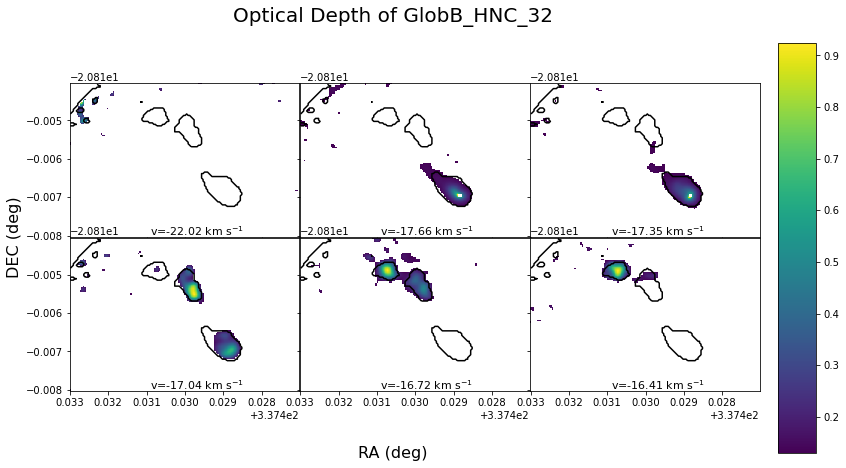

In [19]:
fig = plt.figure(1, figsize=(ncols*3.5, nrows*3))
g = setup_axes(fig)
moment0 = np.sum(data3[array, :, :], axis = 0)

extent=[ra[x1],ra[x2],dec[y1],dec[y2]]

X = 1/(np.exp(hnu_k/2.73)-1)
#Tex = 28.92998995290211
Tex = 23.94604986

moment0 = np.sum(data3[array, :, :], axis = 0)
max_value = np.nanmax(moment0)
  
sigma_mask = sigma_clip(moment0, sigma=3, maxiters=None, cenfunc='mean')
newmask = (moment0 < np.amax(sigma_mask))
    
mom0 = np.ma.array(moment0, mask = newmask)

for i, ax in enumerate(g):
        ax.contour(newmask, levels = 0, colors='k', extent=extent, origin="lower")

for i, ax in enumerate(g):
    opt_data = data3[array[i],:,:]  
    t_mb = 1.222e3*opt_data*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    den = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb/hnu_k
    almost = 1-den
    there = -np.log(almost)
    
    sigma_mask = sigma_clip(there, sigma=3, maxiters=None, cenfunc='mean')
    newmask = (there < np.amax(sigma_mask))
    od_map = np.ma.array(there, mask = newmask)
    
    im = ax.imshow(od_map, origin= 'lower', extent=extent, zorder = 0)
    ax.text(0.35, 0.01, 'v=%2.2f km s$^{-1}$' %(velocity[array[i]]), transform=ax.transAxes, fontsize = 11, color = 'k')
    
fig.suptitle('Optical Depth of ' + source, fontsize=20, y=1.01, horizontalalignment='center', verticalalignment='center')
fig.text(0.5, 0, 'RA (deg)',fontsize=16, horizontalalignment='center', verticalalignment='center')
fig.text(0, 0.5, 'DEC (deg)',fontsize=16, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')

plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
#fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, 0, 0.05, 0.95])
fig.colorbar(im, cax=cbar_ax)
plt.show()